特定期間の予測値の総量を知りたい時の95%信頼区間をシミュレーションで求められないか

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import t

pd.options.display.float_format = '{:.5f}'.format

,target
0,112
1,118
2,132
3,129
4,121


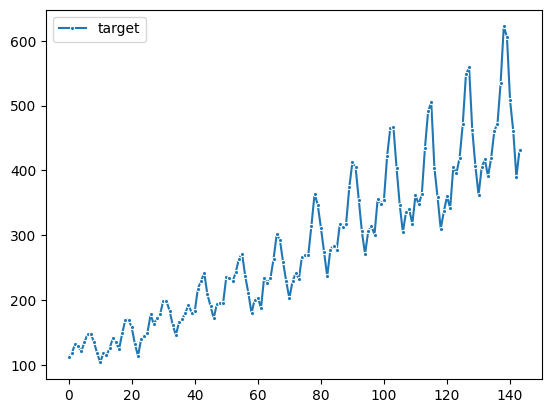

In [2]:
dataset = sm.datasets.get_rdataset('AirPassengers')
df = dataset.data['value'].to_frame(name="target")
display(df.head())

fig, ax = plt.subplots()
sns.lineplot(df, marker='.')
plt.show()

df_train = df.iloc[:-10]
df_test = df.iloc[-10:]

モデリング

In [3]:
# p=1, d=0, q=1, P=1, D=0, Q=1で考える
results = SARIMAX(df_train["target"], order=(1,0,1), seasonal_order=(1,0,1,12),
                            enforce_stationarity = False, enforce_invertibility = False
                           ).fit()

In [4]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             target   No. Observations:                  134
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -435.404
Date:                            Thu, 07 Mar 2024   AIC                            880.807
Time:                                    10:32:06   BIC                            894.745
Sample:                                         0   HQIC                           886.467
                                            - 134                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9154      0.052     17.575      0.000       0.813       1.017
ma.L1         -0.2901      0.084     -3.463      0.001      -0.454      -0.126
ar.S.L12       1.1267      0.011    105.153      0.000       1.106       1.148
ma.S.L12      -0.4638      0.114     -4.061      0.000      -0.688      -0.240
sigma2        80.9550     10.266      7.886      0.000      60.835     101.075
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 9.32
Prob(Q):                              0.74   Prob(JB):                         0.01
Heteroskedasticity (H):               1.49   Skew:                            -0.40
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

予測

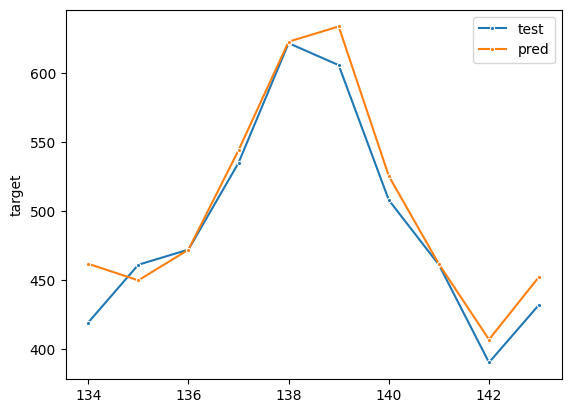

In [5]:
forecast = results.get_forecast(steps=10)
y_pred = forecast.predicted_mean # 各時点の期待値を予測とする

fig, ax = plt.subplots()
#sns.lineplot(df_train["target"], label="train", marker='.')
sns.lineplot(df_test["target"], label="test", marker='.')
sns.lineplot(y_pred, label="pred", marker='.')
plt.show()

In [6]:
display(forecast.predicted_mean) # 各時点の期待値
display(forecast.var_pred_mean) # 各時点の分散

134   461.72502
135   449.64672
136   471.94628
137   544.17055
138   623.04109
139   634.10196
140   525.44412
141   461.46805
142   406.66490
143   452.28110
Name: predicted_mean, dtype: float64

134    80.95502
135   112.60410
136   139.12466
137   161.34776
138   179.96976
139   195.57419
140   208.65003
141   219.60703
142   228.78852
143   236.48221
Name: var_pred_mean, dtype: float64

予測値の総和を求める
  - 作ったモデルでN時点先までを予測する行為を複数回シミュレーションし、シミュレーション結果から各時点までの総和の予測区間を求める
  - SARIMAXのsimulateメソッドを使ってシミュレーションできそう(https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.simulate.html)


In [7]:
# def simulation_of_confidence_intervals(results, nsimulations, repetitions, anchor):
#     """モデリング結果からシミュレーションにより予測値の総和の95%予測区間を求める

#     Args:
#         results (SARIMAXResults): SARIMAXの返り値
#         nsimulations (int): 何時点先まで予測をするか
#         repetitions (int): シミュレーションの実行回数
#         anchor (int): シミュレーションの開始時刻

#     Returns:
#         y (list): 時点hまでの予測値の総和の期待値
#         ci_upper (list): 信頼区間の上限
#         ci_lower (list): 信頼区間の下限
#     """

#     forecast = results.get_forecast(steps=nsimulations)
#     y_pred = forecast.predicted_mean # 予測値を求める
#     simulated_obs = results.simulate(nsimulations=nsimulations, repetitions=repetitions, anchor=anchor) # 推定したパラメータを用いて予測のシミュレーションをする

#     y, ci_upper, ci_lower = [], [], [] # 時点hまでの予測値の総和の期待値、信頼区間の上限、信頼区間の下限
#     for h in range(1, nsimulations+1):
#         simulated_obs_part = simulated_obs.iloc[:h] # 時点hまでの予測値のシミュレーションを取り出す
#         #mean_bar = simulated_obs_part. # h期先までの予測の総和が従う正規分布の期待値
#         y_pred_sum = y_pred[:h].sum() # h期先までの総和をとったものは、正規分布に従い期待値はh期先までの予測値の総和になる
#         y.append(y_pred_sum)
#         std_value = simulated_obs_part.sum(axis=0).std() # シミュレーションを使ってh期先までの総和の標準偏差を求める
#         ci_upper.append(y_pred_sum + 1.96*std_value) # 信頼区間を求める
#         ci_lower.append(y_pred_sum - 1.96*std_value)
#     return y, ci_upper, ci_lower


# nsimulations = 10 # 何時点先まで予測をするか
# repetitions = 10000 # シミュレーションを何回実行するか
# anchor = len(df_train) # シミュレーションの開始時刻(trainの1期先にしたい)

# # 結果のプロット
# y, ci_upper, ci_lower = simulation_of_confidence_intervals(results, nsimulations, repetitions, anchor)
# x = list(range(len(df_train), len(df_train)+nsimulations))
# fig, ax = plt.subplots()
# ax.plot(x, y, marker=".")
# ax.fill_between(x, ci_upper, ci_lower, color='b', alpha=.1)
# plt.show()

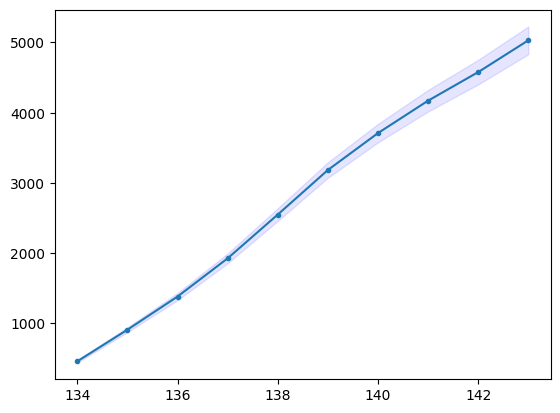

In [8]:
def calculate_prediction_interval(simulated_obs_part, n, p):
    """サンプリングしたデータからp%予測区間を求める

    Args:
        simulated_obs_part (DataFrame): (時点数, シミュレーション回数)のサンプルを入れたDataFrame
        n (int): サンプルサイズ(シミュレーション回数)
        p (float): p%予測区間を求める時のp

    Returns:
        mean_bar (float): 時点hまでの予測値の総和の標本平均
        ci_upper (float): p%予測区間の上限
        ci_lower (float): p%予測区間の下限
    """
    mean_bar = simulated_obs_part.sum(axis=0).mean() # 標本平均を求める
    sn = np.sqrt(np.sum((simulated_obs_part.sum(axis=0) - mean_bar)**2) / (n-1)) # 標準偏差を求める
    ta = t.ppf((1+p)/2, n-1)
    ci = ta*sn*np.sqrt(1+(1/n))
    ci_upper = mean_bar+ci
    ci_lower = mean_bar-ci
    return mean_bar, ci_upper, ci_lower

def simulation_of_prediction_intervals(results, nsimulations, repetitions, anchor, p):
    """モデリング結果からシミュレーションにより予測値の総和の予測区間を求める

    Args:
        results (SARIMAXResults): SARIMAXの返り値
        nsimulations (int): 何時点先まで予測をするか
        repetitions (int): シミュレーションの実行回数
        anchor (int): シミュレーションの開始時刻
        p (float): p%予測区間を求める時のp

    Returns:
        mean_bars (list): 時点hまでの予測値の総和の期待値
        ci_uppers (list): 予測区間の上限
        ci_lowers (list): 予測区間の下限
    """

    forecast = results.get_forecast(steps=nsimulations)
    y_pred = forecast.predicted_mean # 予測値を求める
    simulated_obs = results.simulate(nsimulations=nsimulations, repetitions=repetitions, anchor=anchor) # 推定したパラメータを用いて予測のシミュレーションをする

    mean_bars, ci_uppers, ci_lowers = [], [], [] # 時点hまでの予測値の総和の期待値、予測区間の上限、予測区間の下限
    for h in range(1, nsimulations+1):
        simulated_obs_part = simulated_obs.iloc[:h] # 時点hまでの予測値のシミュレーションを取り出す
        mean_bar, ci_upper, ci_lower, = calculate_prediction_interval(simulated_obs_part, repetitions, p) # 時点hまでの予測値の総和の予測区間を求める
        mean_bars.append(mean_bar)
        ci_uppers.append(ci_upper)
        ci_lowers.append(ci_lower)
    return mean_bars, ci_uppers, ci_lowers


nsimulations = 10 # 何時点先まで予測をするか
repetitions = 10000 # シミュレーションを何回実行するか
anchor = len(df_train) # シミュレーションの開始時刻(trainの1期先にしたい)
p = 0.95

# 結果のプロット
y, ci_upper, ci_lower = simulation_of_prediction_intervals(results, nsimulations, repetitions, anchor, p)
x = list(range(len(df_train), len(df_train)+nsimulations))
fig, ax = plt.subplots()
ax.plot(x, y, marker=".")
ax.fill_between(x, ci_upper, ci_lower, color='b', alpha=.1)
plt.show()
